## Chloropleth for SICRU model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import numpy as np

import matplotlib

### get table 

In [2]:

productpath = "../../results/"
tbpath = productpath
df = pd.read_csv(tbpath + "TableS1RCarIfr_processed.csv") 

print(df.columns)

Index(['Region', 'R0 (CI)', 'Rt(April 15th, 2020) (CI)', 'CAR (week 0) (CI)',
       'CARt(April 15th, 2020) (CI)', 'IFR (week 0) (CI)',
       'IFRt(April 15th, 2020) (CI)', 'delta weeks'],
      dtype='object')


### get rois

In [3]:
rois = list(df.Region.unique())
rois = list(set(rois))

roi_us = np.sort([i for i in rois if i[:2]=='US'])[::-1]
roi_other = np.sort([i for i in rois if i[:2]!='US'])[::-1]
rois = list(roi_us) + list(roi_other)

### make roi dictionaries for cartopy, natural earth

In [4]:
statehash = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [5]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

ct_ = []
for country in countries:
    ct_.append(country.attributes['NAME_LONG'])

ct_=np.sort(ct_)
    
roi2ct = {}
for roi in roi_other:
    for ct in ct_:
#         print(ct)
        if roi in ct:
            roi2ct[roi] = ct
            break
            
roi2ct['Burma'] = 'Myanmar'
roi2ct['Korea, South'] = 'Republic of Korea' 
roi2ct['Czechia'] = 'Czech Republic'
roi2ct['North Macedonia'] = 'Macedonia'
roi2ct['Congo (Brazzaville)'] = 'Republic of the Congo'
roi2ct['Taiwan*'] = 'Taiwan'


ct2roi = {v: k for k, v in roi2ct.items()}

### define geoplot function

In [6]:
def getlastweekID(thetaroot,roi):
    for i in np.arange(11,0,-1):
        theta = thetaroot+' (week '+str(i)+')'
        x = df.loc[(df.roi==roi)&(df['quantile']=='0.5'),theta].values
        if len(x)>0 and np.isfinite(x):
            break
    return theta

def geoplot(thetaroot,thetabool,sc,ax,title,cmap,maptype):

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    # ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    
    
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    
    shpfilename_us = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shpfilename_us)
    states = reader.records()
    

    for ct in countries:
        try:
            ctname = ct.attributes['NAME_LONG']
            roi = ct2roi[ctname] 
            c = sc*float(df.loc[(df.Region==roi), thetaroot].values[0])
            if ct.geometry.type == 'Polygon':
                ct_geo = [ct.geometry]
            else:
                ct_geo = ct.geometry
            ax.add_geometries(ct_geo, maptype, facecolor=cmap(c))
        except:
            if ct.geometry.type == 'Polygon':
                ct_geo = [ct.geometry]
            else:
                ct_geo = ct.geometry
            ax.add_geometries(ct_geo, maptype, facecolor='gray',alpha=0.5)

    for state in states:
        st = (state.attributes['name_alt']).split("|")[0]
        roi = 'US_'+st
        try:
            c = sc*float(df.loc[(df.Region==roi), thetaroot].values[0])
            if state.geometry.type == 'Polygon':
                state_geo = [state.geometry]
            else:
                state_geo = state.geometry
            ax.add_geometries(state_geo, maptype, facecolor=cmap(c))
        except:
            if ct.geometry.type == 'Polygon':
                ct_geo = [ct.geometry]
            else:
                ct_geo = ct.geometry
            ax.add_geometries(ct_geo, maptype, facecolor='gray',alpha=0.5)

    ax.set_title(title+'\n(color scale 0-'+str(1./sc)+', gray=missing data)')
    return

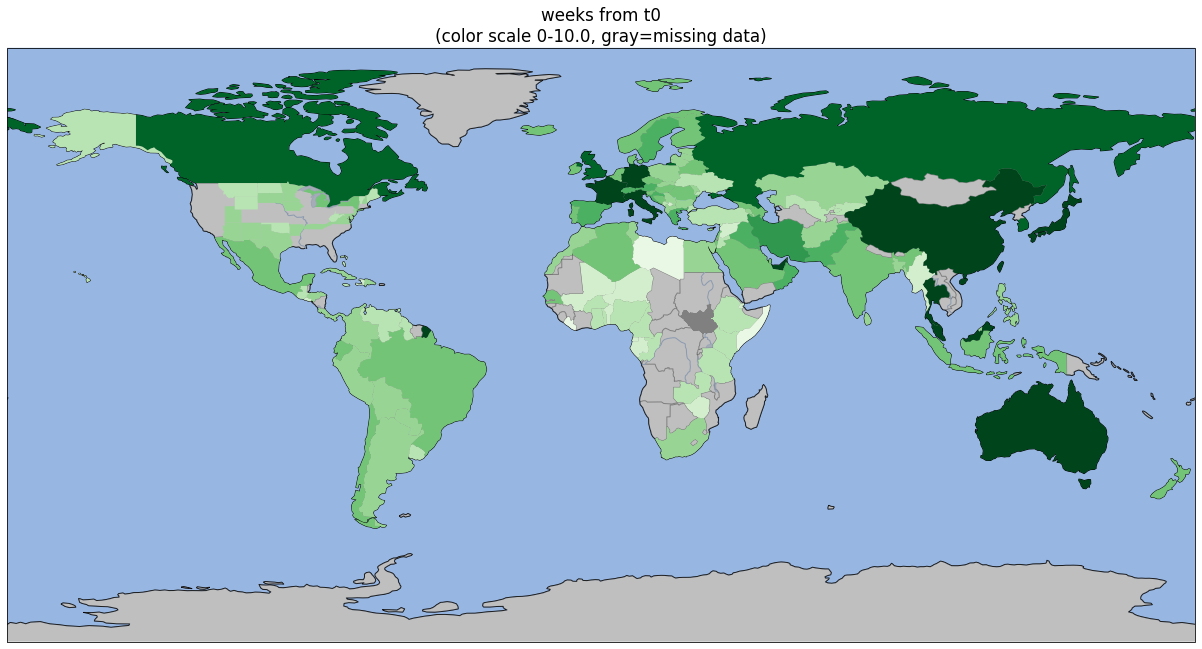

In [7]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

cmap = matplotlib.cm.get_cmap('Greens')

import cartopy.crs as ccrs
maptype = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=maptype),figsize=(15,10))

sc = 0.1
geoplot('delta weeks',0,sc,ax,r'weeks from t0',cmap,maptype)

plt.subplots_adjust(left=-0.05,right=1.05,top=1.0, hspace = 0.25,bottom=0)

plt.savefig(productpath+'deltaweeksgeo.png', dpi=300)
